<a href="https://colab.research.google.com/github/86lekwenshiung/Neural-Network-with-Tensorflow/blob/main/04_Transfer_Learning_with_Tensorflow_Part_1_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.0 Transfer Learning with Tensorflow Part 1 : Feature Extraction
___

Transfer Learning leverages a working model's exisiting architecture and learned patterns for our own problem.

2 main benefits:
  1. Leverage an existing neural network architecture proven to work on similiar , related problems.
  2. Leverage a working neural network architecture which has already learned patterns on similiar pattern on similiar data to our own , then we can adapt those pattern to our own.

<p align = 'center'>
  <img src = 'https://raw.githubusercontent.com/86lekwenshiung/Neural-Network-with-Tensorflow/main/images/04-transfer-learning-feature-extraction.png'>
</p>

### Import Libraries
___

In [25]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D , MaxPool2D , Flatten , Dense

import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import os
import zipfile
import pathlib

### Checking TF version and GPU
___

In [18]:
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
!nvidia-smi

2.6.0
[]
NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



# 1.0 Getting Data from kaggle(food101)
___

In [19]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip 

--2021-08-22 17:09:51--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.128, 74.125.137.128, 142.250.101.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   202MB/s    in 0.8s    

2021-08-22 17:09:52 (202 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [20]:
# Unzip File
zip_ref = zipfile.ZipFile(file = '10_food_classes_10_percent.zip' , mode = 'r')

# Extract File
zip_ref.extractall()

# Close Zip
zip_ref.close()

### 1.1 Setting Up File Path
___

In [10]:
for dirpaths , dirnames , filenames in os.walk('10_food_classes_10_percent'):
  print(f'There are {len(filenames)} files and {len(dirnames)} folders in {dirpaths}')

There are 0 files and 2 folders in 10_food_classes_10_percent
There are 0 files and 10 folders in 10_food_classes_10_percent/test
There are 250 files and 0 folders in 10_food_classes_10_percent/test/ramen
There are 250 files and 0 folders in 10_food_classes_10_percent/test/steak
There are 250 files and 0 folders in 10_food_classes_10_percent/test/chicken_curry
There are 250 files and 0 folders in 10_food_classes_10_percent/test/ice_cream
There are 250 files and 0 folders in 10_food_classes_10_percent/test/chicken_wings
There are 250 files and 0 folders in 10_food_classes_10_percent/test/hamburger
There are 250 files and 0 folders in 10_food_classes_10_percent/test/grilled_salmon
There are 250 files and 0 folders in 10_food_classes_10_percent/test/fried_rice
There are 250 files and 0 folders in 10_food_classes_10_percent/test/pizza
There are 250 files and 0 folders in 10_food_classes_10_percent/test/sushi
There are 0 files and 10 folders in 10_food_classes_10_percent/train
There are 75 

### 1.2 Setting Up File Directory
___

In [11]:
train_dir = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'

### 1.3 Setting Up Class Names
___

In [15]:
"""
PurePath subclass that can make system calls.

Path represents a filesystem path but unlike PurePath, also offers 
methods to do system calls on path objects. Depending on your system,
instantiating a Path will return either a PosixPath or a WindowsPath
object. You can also instantiate a PosixPath or WindowsPath directly,
but cannot instantiate a WindowsPath on a POSIX system or vice versa.
"""

data_dir = pathlib.Path(train_dir)

for item in data_dir.glob('*'):
  print(item.name)

ramen
steak
chicken_curry
ice_cream
chicken_wings
hamburger
grilled_salmon
fried_rice
pizza
sushi


In [16]:
class_names = [item.name for item in data_dir.glob('*')]

### 1.4 Visualing Data
___

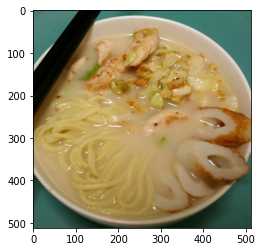

In [51]:
# How to Read Sample Image File From Directories

sample_path  = '/content/10_food_classes_10_percent/train/ramen'
random_image = random.choice(os.listdir(sample_path))

img = plt.imread(sample_path + '/' + random_image)
plt.imshow(img)

In [95]:
def view_random_image(target_dir , target_class):
  # File Path to Img
  file_path = target_dir + '/' + target_class

  # Random Image
  random_image = random.choice(os.listdir(file_path))

  img = plt.imread(file_path + '/' + random_image)
  plt.imshow(img)
  plt.title(f'{target_class} , {img.shape}')
  plt.axis(False)
  plt.xlabel(f'image shape: {img.shape}');

  return img

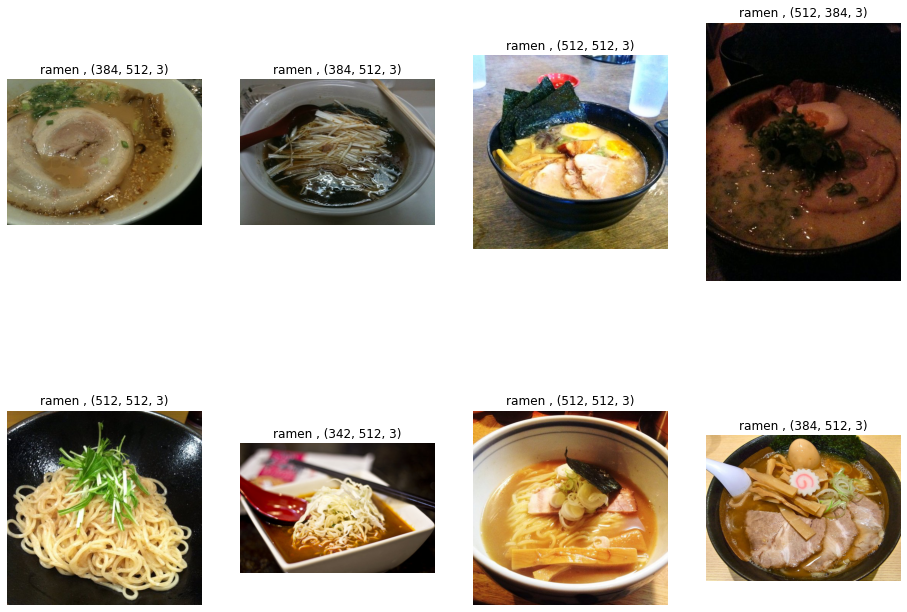

In [96]:
plt.figure(figsize = (16,12))
for i in range(8):
  plt.subplot(2,4,i+1)
  img = view_random_image(target_dir = '/content/10_food_classes_10_percent/train', 
                        target_class = 'ramen')

# 2.0 Building Baseline Model
___
1. Define Rescale function and file dir
2. Load and preprocess image
3. Build a model
4. Compile a model 
5. Fit the model and evaluating loss curves
6. Hyperparameter tuning , Augmenting Data

### 2.1 Define Rescale Function
___

In [42]:
img_shape = (224 , 224)
batch_size = 32

train_datagen = ImageDataGenerator(rescale = 1/255)
test_datagen = ImageDataGenerator(rescale = 1/255)

train_data_10percent = train_datagen.flow_from_directory(directory = train_dir,
                                                        target_size = img_shape,
                                                        class_mode = 'categorical',
                                                        batch_size = batch_size)

test_data_10percent = test_datagen.flow_from_directory(directory = test_dir,
                                                       target_size = img_shape,
                                                       class_mode = 'categorical',
                                                       batch_size = batch_size)

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


### 2.2 Setting Up Callbacks
___

More commonly used callbacks
1. [TensorBoard](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard)
2. EarlyStopping
3. Model checkpointing


|Callback name|User Case|Code|
|---|---|---|
|TensorBoard| Log the Performance of multiple models and then view and compares these models in a visual way on TensorBoard|tf.keras.callbacks.TensorBoard()|
|Model checkpointing| Save your model as it trains so ytou can stop training if needed and come back to continue off where you left. Helpful for long training time and can't be done in one sitting| tf.keras.callbacks.ModelCheckpoint|
|Early stopping| Leave your model for an arbitary amount of tiume and have it stop training automatically when it ceaes to improve. Helpful when there ia a large dtaasetr and don't know how long training will take.| tf.keras.callbacks.EarlyStopping()|

In [97]:
import datetime

def create_tensorboard_callback(dir_name , experiment_name):
  log_dir = dir_name + '/' +experiment_name +'/' +datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f'Saving Tensorboard log files to {log_dir}')
  return tensorboard_callback